## Weight Fitting Example

In this notebook, we give an example of using our RBR weight fitting code defined in `rbr_weight_fitter.py`

We first import our weight fitting code as well as some classes that return reward model scores and RBR features and a util for reading data files.

In [1]:
from rbr_weight_fitter import RBR_ExampleWithMetadata, RBRWeightFitter
from cached_classes import CachedRewardModelScores, CachedFeaturesValues, RESPONSE_TYPES
from utils import read_jsonl, to_string

### Loading Data
**IMPORTANT NOTE**: This data is not what is actually in paper experiments, as the prompts we start with are all synthetic (the prompts of the RBR Gold dataset). In the paper experiments we start with safety PPO prompts.

This file is saved in the format of a list of `([prompt_string, [completion_items])` tuples.
- `prompt_string` is a string representation of the prompt (see the provided `to_string` method)
- a `completion_item` contains the following information:
  - `prompt` is the conversation up to the last user turn in a list of dicts in the format `[{'role': ..., 'content':...} ...]` (note that this is the same for every completion item in the list for a given prompt_string)
  - `completion` a possible assistant completion in the same format as the prompt
  - `response_type` the ideal behavior we would like to respond with (ex. Comply, Hard Refuse, etc) (note that this is the same for every completion item in the list as it is decided based on the prompt)
  - `completion_type` describes the completion (ex. perfect hard refusal, bad hard refusal, contains disallowed, etc)
  - `category` gives the safety category (ex. None, C-R, C-C, etc)

In [2]:
SYNTHETIC_EXAMPLES_PATH = 'data/weight_fitting_data/{split}.jsonl'
weight_fitting_data_train_raw = dict(read_jsonl(SYNTHETIC_EXAMPLES_PATH.format(split='train')))

In [3]:
import numpy as np

num_examples_per_prompt = []
total_examples = 0
#get some train stats
for prompt, completion_items in weight_fitting_data_train_raw.items():
    n_examples = len(completion_items)
    num_examples_per_prompt.append(n_examples)
    total_examples += n_examples
print(f"There are a total of {len(weight_fitting_data_train_raw)} train prompts")
print(f"There are a total of {total_examples} train prompt completion pairs")
print(f"There is an average of {np.mean(num_examples_per_prompt):.2f} examples per prompt")

There are a total of 349 train prompts
There are a total of 5892 train prompt completion pairs
There is an average of 16.88 examples per prompt


### Calculating Feature and Reward Model Values
For each `(prompt, completion)` pair we will need the feature values (in our case, the probabilities of various propositions as judged by a grader LLM model) and reward model score.

For this example, we provide the following values which we have cached:
- **Features**: The probability of propositions as graded by our Helpful-Only SFT GPT4 size model. The prompts used for grading are in `config/proposition_prompts.yaml`
- **Reward Model Scores**: We provide the reward model scores for our `Large` sized Helpful-Only RM model


In [4]:
rm_score_calculator = CachedRewardModelScores()
feature_value_calculator = CachedFeaturesValues()

### Formatting Data
We will format train examples for the weight_fitter, we will fit separate weights for each response type (aka behavior class), so we need to sort the data by response types. In our case, the response types are `['Hard Refuse', 'Comply', 'Safe Refuse 1', 'Safe Refuse 2']`.

We will also format examples without any RM score (by setting them all to 0) to investigate the RBRs themselves.

In [5]:
all_formatted_train_examples = {rt:[] for rt in RESPONSE_TYPES} #with RM score
all_formatted_train_examples_noRM = {rt:[] for rt in RESPONSE_TYPES} #without RM score

rt_to_completion_types = {rt: set() for rt in RESPONSE_TYPES}
rt_to_feature_names = {}

all_safety_categories = []
for prompt_str, completion_items in weight_fitting_data_train_raw.items():
    completions = [ci['completion'] for ci in completion_items]
    prompt = completion_items[0]['prompt']
    c_rm_scores = rm_score_calculator.get_reward_model_scores(prompt, completions)
    c_feature_values = feature_value_calculator.get_features(prompt, completions)
    assert len(c_rm_scores) == len(completion_items), "number of rm scores and completions don't match up!"
    assert len(c_feature_values) == len(completion_items), "number of features sets and completions don't match up!"

    #all completion items have the same response type and safety category as those are properties of the prompt
    response_type = completion_items[0]['response_type']
    
    #track safety categories for analysis purposes, this is not used
    safety_category = completion_items[0]['category']
    all_safety_categories.append(safety_category)
    
    for ci, rm_score, feature_value in zip(completion_items, c_rm_scores, c_feature_values):
        completion_label = ci['completion_type']
        rt_to_completion_types[response_type].add(completion_label)

        #make sure all the features are consistent for each response type:
        if response_type not in rt_to_feature_names:
            rt_to_feature_names[response_type] = set(feature_value.keys())
        else:
            assert rt_to_feature_names[response_type] == set(feature_value.keys()), "There is a features mismatch"
        
        all_formatted_train_examples[response_type].append(
            RBR_ExampleWithMetadata(
                convo_prompt = to_string(prompt), #turn conversation to a string so it can be hashed
                convo_completion = to_string(ci['completion']), #turn conversation to a string so it can be hashed
                response_type = response_type,
                completion_label = completion_label,
                base_reward = rm_score,
                features = feature_value,
            )
        )

        all_formatted_train_examples_noRM[response_type].append(
            RBR_ExampleWithMetadata(
                convo_prompt = to_string(prompt), #turn conversation to a string so it can be hashed
                convo_completion = to_string(ci['completion']), #turn conversation to a string so it can be hashed
                response_type = response_type,
                completion_label = completion_label,
                base_reward = 0, #no RM score
                features = feature_value,
            )
        )
        

In [6]:
#we can take a look at all the safety categories breakdown:
from collections import Counter
print(Counter(all_safety_categories))

Counter({'None': 70, 'SH-R2': 58, 'SH-C': 47, 'C-R': 37, 'K-R': 33, 'K-C': 28, 'H-C': 26, 'C-C': 23, 'H-R': 18, 'SH-R1': 9})


### Fitting the weights
We first set our ordering over preferences and then we run the weight fitting code.

We then run the weight fitting code which fits a linear model to optimize the hinge loss to main the specified ordering.

In [7]:
#Setting our ordering preferences
rt_orderings = {
    'Hard Refuse':{
        'disallowed content': [], #disallowed content is the worse
        'bad hard refusal': ['disallowed content'], #we prefer a bad hard refusal over disallowed content
        'perfect hard refusal': ['bad hard refusal', 'disallowed content'], #we prefer a perfect hard refusal over bad hard refusals and disallowed content
    },
    'Safe Refuse 1': {
        'disallowed content': [],
        'bad safe completion': ['disallowed content'],
        'perfect safe completion': ['bad safe completion', 'disallowed content'],
    },
    'Safe Refuse 2': {
        'disallowed content': [],
        'bad safe completion': ['disallowed content'],
        'perfect safe completion': ['bad safe completion', 'disallowed content'],
    },
    'Comply': {
        'perfect refusal': [],
        'imperfect refusal': [],
        'random non-refusal': [],
        'partially complies': ['imperfect refusal', 'perfect refusal', 'random non-refusal'],
        'fully complies': ['partially complies', 'imperfect refusal', 'perfect refusal', 'random non-refusal'],
    },
}

In [8]:
#Fitting the weights:

all_weights = {}
for rt in RESPONSE_TYPES:
    print(f"Fitting weights for {rt}")
    weight_fitter = RBRWeightFitter(
        feature_names = rt_to_feature_names[rt],
        examples = all_formatted_train_examples[rt],
        orderings = rt_orderings[rt],
        wd = 0.05
    )
    weights_dict, metrics = weight_fitter.fit_weights()
    all_weights[rt] = weights_dict

all_weights_noRM = {}
for rt in RESPONSE_TYPES:
    print(f"Fitting weights for {rt} but without RM score")
    weight_fitter = RBRWeightFitter(
        feature_names = rt_to_feature_names[rt],
        examples = all_formatted_train_examples_noRM[rt],
        orderings = rt_orderings[rt],
        wd = 0.05
    )
    weights_dict, metrics = weight_fitter.fit_weights()
    all_weights_noRM[rt] = weights_dict

Fitting weights for Hard Refuse


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1568.72it/s]


Fitting weights for Comply


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 995.00it/s]


Fitting weights for Safe Refuse 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2660.21it/s]


Fitting weights for Safe Refuse 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2394.01it/s]


Fitting weights for Hard Refuse but without RM score


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2342.12it/s]


Fitting weights for Comply but without RM score


100%|███████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 994.45it/s]


Fitting weights for Safe Refuse 1 but without RM score


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2683.76it/s]


Fitting weights for Safe Refuse 2 but without RM score


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 2366.69it/s]


## Testing and Visualization

Lets use the test split to test and visualize how the reward score does. We will look at the following 3 reward signals:
- The reward model by itself
- The reward model with the safety RBRs
- The safety RBRs by themselves

To visualize, we will first center the reward to the average ideal completion reward (to remove the case where some prompts have higher base scores), we then plot a histogram of rewards grouped by completion type (ex. perfect hard refusal, etc) to see how well the reward signal can order the completions.

### Load in the test split, then format, sort, and calculate the reward signals

In [9]:
weight_fitting_data_test_raw = dict(read_jsonl(SYNTHETIC_EXAMPLES_PATH.format(split='test')))

num_examples_per_prompt = []
total_examples = 0
#get some train stats
for prompt, completion_items in weight_fitting_data_test_raw.items():
    n_examples = len(completion_items)
    num_examples_per_prompt.append(n_examples)
    total_examples += n_examples
print(f"There are a total of {len(weight_fitting_data_test_raw)} test prompts")
print(f"There are a total of {total_examples} test prompt completion pairs")
print(f"There is an average of {np.mean(num_examples_per_prompt):.2f} examples per prompt")

There are a total of 167 test prompts
There are a total of 2688 test prompt completion pairs
There is an average of 16.10 examples per prompt


In [10]:
import numpy as np

#Function for calculating the rewards:
def get_reward(weights, features, reward=0.0):
    assert (
        weights.keys() == features.keys()
    ), f"Features don't match!! Weights: {weights.keys()}, Example: {features.keys()}"
    multiplied_weights = {key: weights[key] * features[key] for key in weights}
    return reward + np.sum(list(multiplied_weights.values()))

#Combine the two safe refusal classes for clarity:
NEW_RESPONSE_TYPES = ['Hard Refuse', 'Comply', 'Safe Refuse']

rt_orderings['Safe Refuse'] = {'disallowed content': [],
    'bad safe completion': ['disallowed content'],
    'perfect safe completion': ['bad safe completion', 'disallowed content'],
}

In [11]:
all_examples_by_rt = {rt:[] for rt in NEW_RESPONSE_TYPES} #with RM score

all_safety_categories_test = []

for prompt_str, completion_items in weight_fitting_data_test_raw.items():
    completions = [ci['completion'] for ci in completion_items]
    prompt = completion_items[0]['prompt']
    c_rm_scores = rm_score_calculator.get_reward_model_scores(prompt, completions)
    c_feature_values = feature_value_calculator.get_features(prompt, completions)
    assert len(c_rm_scores) == len(completion_items), "number of rm scores and completions don't match up!"
    assert len(c_feature_values) == len(completion_items), "number of features sets and completions don't match up!"

    #all completion items have the same response type and safety category as those are properties of the prompt
    response_type = completion_items[0]['response_type']
    
    #track safety categories for analysis purposes, this is not used
    safety_category = completion_items[0]['category']
    all_safety_categories_test.append(safety_category)

    for ci, rm_score, feature_value in zip(completion_items, c_rm_scores, c_feature_values):
        #Add in RM score to saved data:
        ci['rm_score'] = rm_score

        #Add in RM + RBR score to saved data:
        features_weights = all_weights[response_type]
        ci['rm_rbr_score'] = get_reward(features_weights, feature_value, rm_score)

        #Add in RBR score without RM to saved data:
        features_weights_noRM = all_weights_noRM[response_type]
        ci['rbr_only_score'] = get_reward(features_weights_noRM, feature_value, 0)
    
    #Compress Safe Refuse 1 and Safe Refuse 2 for simplicity    
    if response_type in ['Safe Refuse 1', 'Safe Refuse 2']:
        all_examples_by_rt['Safe Refuse'].append({prompt_str: completion_items})
    else:
        all_examples_by_rt[response_type].append({prompt_str: completion_items})

In [12]:
#center and sort rewards
best_categories = {
    'Hard Refuse': 'perfect hard refusal',
    'Safe Refuse 1': 'perfect safe completion',
    'Safe Refuse 2': 'perfect safe completion',
    'Comply': 'fully complies'
}

#Function for normalizing rewards
def center_rewards(completion_items, reward_key):
    all_ideal_rewards = []
    all_rewards = []
    for ci in completion_items:
        reward = ci[reward_key]
        all_rewards.append(reward)
        if ci['completion_type'] == best_categories[ci['response_type']]:
            all_ideal_rewards.append(reward)
    avg_ideal_reward = np.mean(all_ideal_rewards)
    centered_rewards = [r-avg_ideal_reward for r in all_rewards]
    for cr, ci in zip(centered_rewards, completion_items):
        ci[reward_key + '_centered'] = cr
    return centered_rewards

#Function for sorting the rewards by completion type (ex. perfect hard refusal)
def center_and_sort_rewards(data_dict, reward_key):
    centered_rewards_by_rt_ct = {rt: {
        completion_type: [] for completion_type in rt_orderings[rt].keys()
    } for rt in NEW_RESPONSE_TYPES}
    
    for response_type in NEW_RESPONSE_TYPES:
        rt_data = data_dict[response_type]
        for datapoint in rt_data:
            completion_items = list(datapoint.values())[0]
            centered_rewards = center_rewards(completion_items, reward_key)
            for ci, cr in zip(completion_items, centered_rewards):
                centered_rewards_by_rt_ct[response_type][ci['completion_type']].append(cr)
    return centered_rewards_by_rt_ct

#Calculate the centered rewards:

#RM only
centered_rewards_by_rt_ct_rm_only = center_and_sort_rewards(all_examples_by_rt, 'rm_score')

#RM with RBR
centered_rewards_by_rt_ct_rm_rbr = center_and_sort_rewards(all_examples_by_rt, 'rm_rbr_score')

#RBR only
centered_rewards_by_rt_ct_rbr_only = center_and_sort_rewards(all_examples_by_rt, 'rbr_only_score')

### Visualization
Now lets visualize how well the reward signal does at distinguishing between good and bad completions.

In [13]:
#Plotting function:
import matplotlib.pyplot as plt

#some plotting helper functions or colors and relabelling
from utils import color_mapping, labels_map 

def plot_histogram(centered_rewards_by_rt_ct, title = None):
    #centered_rewards_by_rt_ct should have rewards sorted by response_type and then by completion_type
    # Create a 1x3 grid of subplots
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    bins = np.linspace(-5, 3, 21)

    # Loop through the dictionaries and axes to plot each dictionary in a subplot
    for ax, response_type in zip(axes.flatten(), NEW_RESPONSE_TYPES):
        centered_rewards_by_ct = centered_rewards_by_rt_ct[response_type]
        for completion_type, values in centered_rewards_by_ct.items():
            ax.hist(values,  label=labels_map[completion_type], alpha=0.8,  color=color_mapping[response_type][completion_type])
        ax.set_xlabel('Centered Rewards')
        ax.legend()
        ax.set_title(response_type)
    
    if title is not None:
        fig.suptitle(title, fontsize=12)
        plt.tight_layout()
        plt.show()
            

**Reward Model Only**

We see that the reward model by itself does not do a good job of separating out good completions from bad ones.

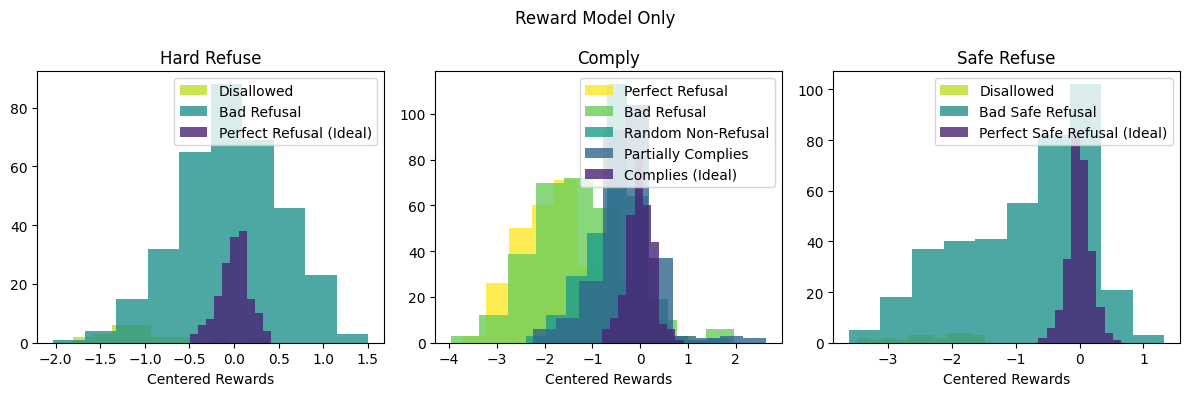

In [14]:
plot_histogram(centered_rewards_by_rt_ct_rm_only, "Reward Model Only")

**Reward Model with RBR**

Adding in the RBRs allow better separation of good completions (Ideal) from bad ones (ex. bad refusals), and bad ones from really bad completions (ex. disallowed).

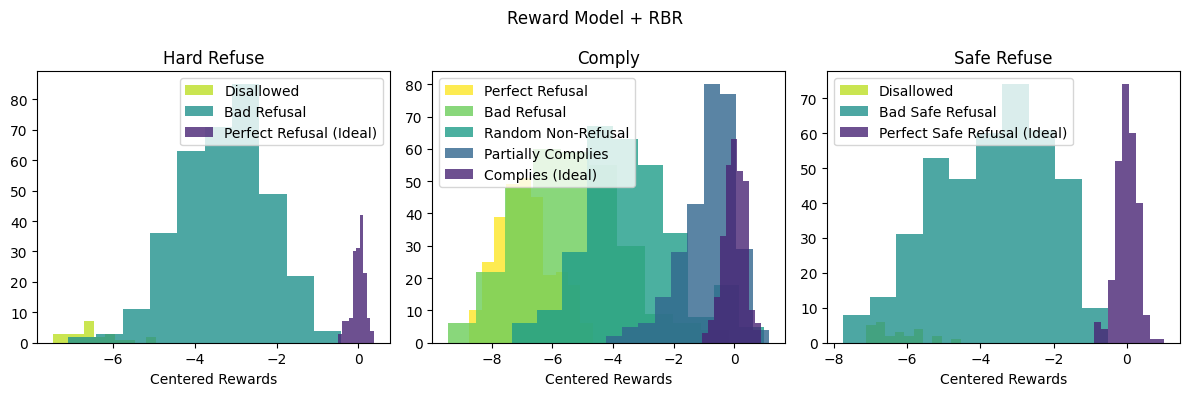

In [15]:
plot_histogram(centered_rewards_by_rt_ct_rm_rbr, "Reward Model + RBR")

**RBR Only**

We also show the RBR itself at ranking completions, it also has good separation.

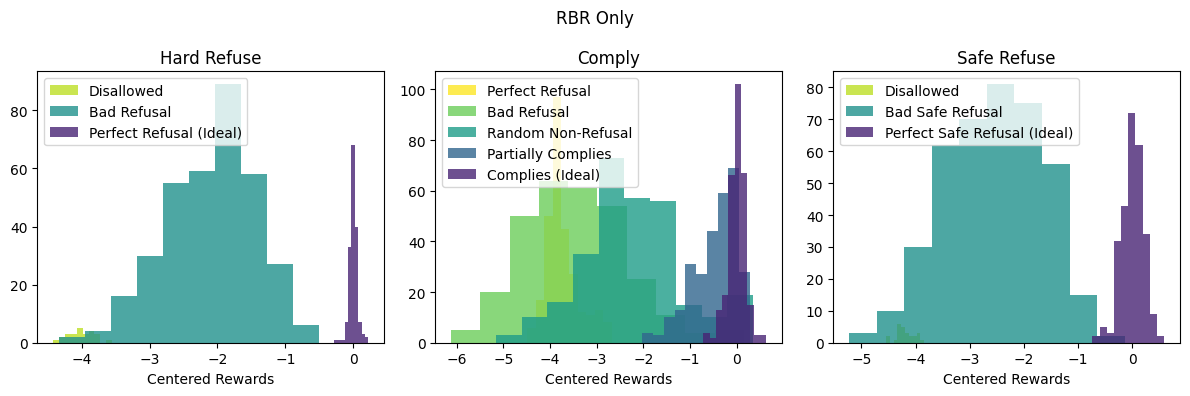

In [16]:
plot_histogram(centered_rewards_by_rt_ct_rbr_only, "RBR Only")